In [1]:
!pip install transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import torch
from torch.utils.data import Dataset
import torch.nn.utils.rnn as rnn_utils

from torchtext import data

In [3]:
# Check if cuda available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Preprocessing Data

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")

In [5]:
class Custom_Text_Dataset(Dataset):
    def __init__(self, df_dir, tokenizer):
        self.df = pd.read_csv(df_dir)
        self.tokenizer = tokenizer

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        text = self.df['post_message'][idx]

        label = self.df['label'][idx]
        label = torch.tensor(label, dtype=torch.long)

        tokens = self.tokenizer.tokenize(text)

        ids = self.tokenizer.convert_tokens_to_ids(tokens)
        ids = torch.tensor(ids, dtype=torch.long)

        length = ids.shape
        length = torch.tensor(length, dtype=torch.float32)
        # ids = torch.tensor(ids, dtype=torch.long)
        # Add 0 so that length of all ids is 7180
        # ids = torch.cat((ids, torch.zeros(7180 - len(ids), dtype=torch.long)))

        return ids, length, label

In [6]:
train_ds = Custom_Text_Dataset('/content/train.csv', tokenizer)
test_ds = Custom_Text_Dataset('/content/test.csv', tokenizer)
valid_ds = Custom_Text_Dataset('/content/val.csv', tokenizer)

In [7]:
from torch.utils.data import DataLoader

def custom_collate_fn(batch):
    sorted_batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
    return sorted_batch

train_dl = DataLoader(train_ds, batch_size=64, collate_fn=custom_collate_fn)
test_dl = DataLoader(test_ds, batch_size=64, collate_fn=custom_collate_fn)
valid_dl = DataLoader(valid_ds, batch_size = 64, collate_fn = custom_collate_fn)


In [8]:
training_dl = [ ]
for batch in train_dl:
    X = [torch.tensor(member[0]) for member in batch]
    padded_X = rnn_utils.pad_sequence(X, batch_first=True)
    training_dl.append([padded_X, torch.tensor([member[1] for member in batch]), torch.tensor([member[2] for member in batch])])

<ipython-input-8-557e0d167fb8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(member[0]) for member in batch]


In [9]:
testing_dl = [ ]
for batch in test_dl:
    X = [torch.tensor(member[0]) for member in batch]
    padded_X = rnn_utils.pad_sequence(X, batch_first=True)
    testing_dl.append([padded_X, torch.tensor([member[1] for member in batch]), torch.tensor([member[2] for member in batch])])

<ipython-input-9-2301d6a2f884>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(member[0]) for member in batch]


In [10]:
validing_dl = [ ]
for batch in valid_dl:
    X = [torch.tensor(member[0]) for member in batch]
    padded_X = rnn_utils.pad_sequence(X, batch_first=True)
    validing_dl.append([padded_X, torch.tensor([member[1] for member in batch]), torch.tensor([member[2] for member in batch])])

<ipython-input-10-70c2a6c926af>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(member[0]) for member in batch]


## Model LSTM

In [11]:
# Pytorch's nn module has lots of useful feature
import torch.nn as nn

class LSTMNet(nn.Module):

    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,bidirectional,dropout):

        super(LSTMNet,self).__init__()

        # Embedding layer converts integer sequences to vector sequences
        self.embedding = nn.Embedding(vocab_size,embedding_dim)

        # LSTM layer process the vector sequences
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )

        # Dense layer to predict
        self.fc = nn.Linear(hidden_dim * 2,output_dim)
        # Prediction activation function
        self.sigmoid = nn.Sigmoid()


    def forward(self,text,text_lengths):
        embedded = self.embedding(text).to(device)

        # Thanks to packing, LSTM don't see padding tokens
        # and this makes our model better
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)

        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)

        # Concatenating the final forward and backward hidden states
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.sigmoid(dense_outputs)

        return outputs

In [12]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")
vocab_size = tokenizer.vocab_size - 1
embedding_dim = 100
hidden_dim = 64
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0.2

model = LSTMNet(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)


In [13]:
import torch.optim as optim
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-4)
criterion = nn.BCELoss()
criterion = criterion.to(device)

In [14]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)

    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [15]:
def train(model,iterator,optimizer,criterion):

    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for batch in iterator:
        # cleaning the cache of optimizer
        optimizer.zero_grad()

        text,text_lengths = batch[0], batch[1]
        text = text.to(device)
        text_lengths = text_lengths

        # forward propagation and squeezing
        predictions = model(text,text_lengths)

        y_test = batch[2].reshape(-1,1)
        y_test = y_test.to(device)
        # computing loss / backward propagation

        loss = criterion(predictions,y_test.float())
        loss.backward()

        # accuracy
        acc = binary_accuracy(predictions,y_test.float())

        # updating params
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    # It'll return the means of loss and accuracy
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [16]:
def evaluate(model,iterator,criterion):

    epoch_loss = 0.0
    epoch_acc = 0.0

    # deactivate the dropouts
    model.eval()

    # Sets require_grad flat False
    with torch.no_grad():
        for batch in iterator:
            text,text_lengths = batch[0],batch[1]
            text = text.to(device)

            predictions = model(text,text_lengths)

            #compute loss and accuracy
            y_test = batch[2].reshape(-1,1)
            y_test = y_test.to(device)

            loss = criterion(predictions, y_test.float())

            acc = binary_accuracy(predictions, y_test.float())

            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
model.load_state_dict(torch.load('/content/model.pth'))
model = model.to(device)


In [41]:
EPOCH_NUMBER = 40
best_valid = 0.96

for epoch in range(1,EPOCH_NUMBER+1):

    train_loss,train_acc = train(model,training_dl,optimizer,criterion)

    test_loss,test_acc = evaluate(model,testing_dl,criterion)
    valid_loss, valid_acc = evaluate(model, validing_dl, criterion)

    # Showing statistics
    print(f'\tTrain Loss: {train_loss:.3f} | Train. Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid. Acc: {valid_acc*100:.2f}%')
    if (valid_acc >= best_valid ):
      best_valid = valid_acc
      torch.save(model.state_dict(), 'model.pth')
      print(f'Test. Acc: {test_acc*100:.2f}%')
    print()

	Train Loss: 0.003 | Train. Acc: 99.92%
	Valid Loss: 0.370 | Valid. Acc: 94.65%

	Train Loss: 0.001 | Train. Acc: 99.98%
	Valid Loss: 0.366 | Valid. Acc: 93.87%

	Train Loss: 0.000 | Train. Acc: 100.00%
	Valid Loss: 0.360 | Valid. Acc: 94.98%

	Train Loss: 0.000 | Train. Acc: 100.00%
	Valid Loss: 0.360 | Valid. Acc: 95.18%

	Train Loss: 0.000 | Train. Acc: 99.99%
	Valid Loss: 0.365 | Valid. Acc: 94.26%

	Train Loss: 0.001 | Train. Acc: 99.98%
	Valid Loss: 0.366 | Valid. Acc: 93.68%

	Train Loss: 0.003 | Train. Acc: 99.93%
	Valid Loss: 0.386 | Valid. Acc: 93.09%

	Train Loss: 0.003 | Train. Acc: 99.86%
	Valid Loss: 0.436 | Valid. Acc: 94.07%

	Train Loss: 0.000 | Train. Acc: 100.00%
	Valid Loss: 0.429 | Valid. Acc: 94.13%

	Train Loss: 0.000 | Train. Acc: 100.00%
	Valid Loss: 0.410 | Valid. Acc: 94.13%

	Train Loss: 0.000 | Train. Acc: 100.00%
	Valid Loss: 0.406 | Valid. Acc: 94.13%

	Train Loss: 0.000 | Train. Acc: 100.00%
	Valid Loss: 0.405 | Valid. Acc: 94.33%

	Train Loss: 0.000 | T

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


In [44]:
model.load_state_dict(torch.load('/content/model_8684.pth'))
model = model.to(device)

Loss: 0.3649 | Accuracy: 0.9583 | Precision: 0.9429 | Recall: 0.8049 | F1: 0.8684


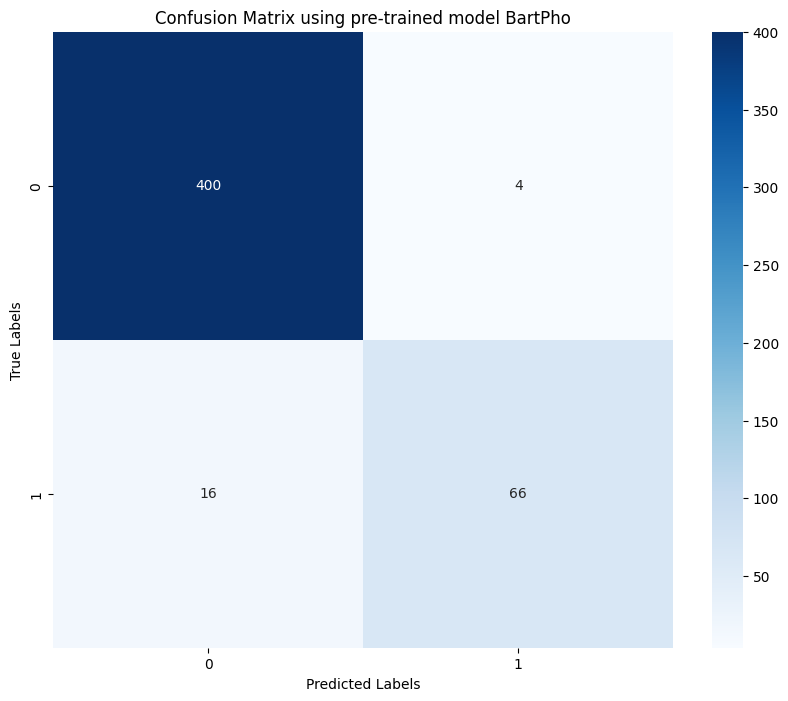

In [45]:
def evaluate2(model, iterator, criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0
    y_true = []
    y_pred = []

    # deactivate the dropouts
    model.eval()

    # Sets require_grad flat False
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch[0], batch[1]
            text = text.to(device)

            predictions = model(text, text_lengths)
            y_test = batch[2].reshape(-1, 1)
            y_test = y_test.to(device)

            loss = criterion(predictions, y_test.float())

            acc = binary_accuracy(predictions, y_test.float())

            # Keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()

            # Append predicted and true labels to the lists
            y_pred.extend(torch.round(predictions).cpu().numpy())
            y_true.extend(y_test.cpu().numpy())

    avg_loss = epoch_loss / len(iterator)
    avg_acc = epoch_acc / len(iterator)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return avg_loss, avg_acc, precision, recall, f1, accuracy, y_true, y_pred


loss, accuracy, precision, recall, f1, accuracy_sklearn, true_labels, predicted_labels = evaluate2(model, validing_dl, criterion)

# Print the evaluation metrics
print(f"Loss: {loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix using pre-trained model BartPho')
plt.show()


In [46]:
def input_test(text, tokenizer, model, device):
    tokens = tokenizer.tokenize(text)
    ids = tokenizer.convert_tokens_to_ids(tokens)
    ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0)

    ids = ids.to(device)

    # Get the length of the input sequence
    length = torch.tensor(ids.shape[1], dtype=torch.long).unsqueeze(0)

    # Evaluate the model on the input text
    with torch.no_grad():
        model.eval()
        predictions = model(ids, length)


    binary_predictions = torch.round(predictions).cpu().numpy()

    return binary_predictions[0][0]


In [59]:
A = input("Enter the text you want to test: ")
result = input_test(A, tokenizer, model, device)

if (int(result) == 0):
  print("Đây là tin thật")
else:
  print("Đây là tin giả")

print("Predicted Label:", result)

Enter the text you want to test: Hoa hậu Ý Nhi đáp trả Quế Ngọc Hải: ‘Tôi học cao hơn anh’ . Sau khi bị Quế Ngọc Hải cà khịa, Hoa hậu Ý nhi ngay lập tức đáp trả.
Đây là tin giả
Predicted Label: 1.0


In [58]:
print("Hoa hậu Ý Nhi đáp trả Quế Ngọc Hải: ‘Tôi học cao hơn anh’ \n  Sau khi bị Quế Ngọc Hải cà khịa, Hoa hậu Ý nhi ngay lập tức đáp trả.")

Hoa hậu Ý Nhi đáp trả Quế Ngọc Hải: ‘Tôi học cao hơn anh’ 
  Sau khi bị Quế Ngọc Hải cà khịa, Hoa hậu Ý nhi ngay lập tức đáp trả.


In [36]:
torch.save(model.state_dict(), 'model_8276.pth')